<a href="https://colab.research.google.com/github/curso-iabd-uclm/hadoop/blob/main/Ejemplo_5_4_Spark_Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

**Ecosistema Spark**

- Spark proporciona únicamente  un motor de cómputo 
- Spark es agnóstico respecto al sistema de almacenamiento 
- Casos de uso frecuentes: Transformación de datos , Queries masivas , Aplicación de streaming,  Machine Learning

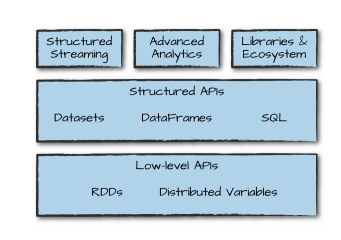

**Arquitectura maestro/esclavo**

-  El proceso driver (*Driver Node*) gestiona la ejecución e informa al usuario 
- Los procesos ejecutores (*Workers Nodes*) procesan las tareas  asignadas por el driver 
- Esta arquitectura es independiente del 
sistema de gestión del cluster (spark, yarn…)

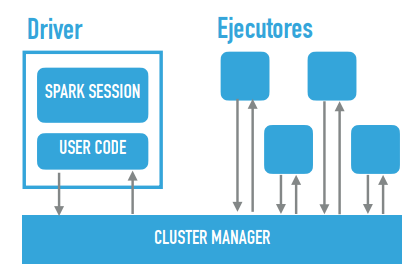

**Jerarquía Cluster de Spark (Standalone)**


Dos tipos de servicios: 

▸ Master coordina los 
procesos driver 

▸ Workers despliegan 
ejecutores (subprocesos)

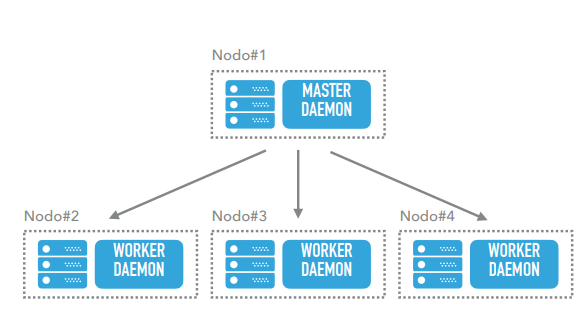

**Datos y Modelo de Ejecución Distribuido**

- Particiones: Fragmento distribuido de los datos 
- Trabajos (job): Operación sobre un conjunto de datos distribuido
- Tareas (tasks): Operación en paralelo sobre una partición





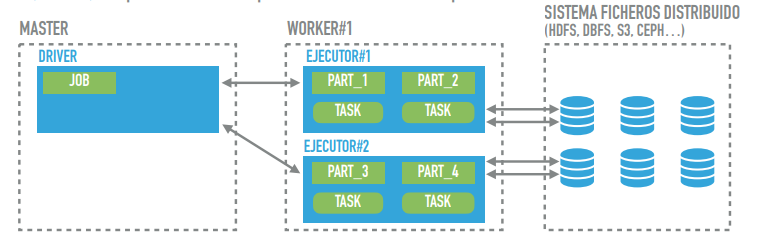

**Transformaciones y acciones**

En spark podemos realizar dos tipos de operaciones sobre un RDD: 

- **Transformaciones**: Convierten cada record del RDD en uno, varios o ninguno. Transforman un RDD en otro RDD 

- **Acciones**: Computan valores sobre todo el RDD o recopilan datos para enviarlos al 
driver. Transforman un RDD en datos secuenciales

Las transformaciones en Spark son perezosas: no computan sus resultados inmediatamente, en cambio recuerdan las transformaciones aplicadas a algún conjunto de datos base. 


# 1. Tutorial

En este tutorial se enseña a utilizar [Apache Spark](https://spark.apache.org) en modo local en un entorno Colab.



## Instalación


En primer lugar instalamos y configuramos todas las dependencias de Spark para Python. 

De esta forma enlazaremos nuestro entorno con el servidor de Spark. 


NOTA: la última versión de PySpark es la 3.1.1 [link](https://pypi.org/project/pyspark/#history)

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar xf spark-3.2.0-bin-hadoop2.7.tgz

!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 212.4 MB 67 kB/s 
     |████████████████████████████████| 198 kB 53.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=33d03732c8dc81a970be087f0ff311d8f8dcaf5e9b9973bc51d29701a8359e40
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


Además configuraremos el entorno Spark con las variables de entorno que sean necesarias.




In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"

## Inicialización 

Vamos a iniciar una sesión de spark simple para testear nuestra instalación

1. Ejecutamos [findspark.init()](https://pypi.org/project/findspark/) para hacer que pyspark sea importable como una biblioteca normal (añade pyspark al sys.path en el entorno de ejecución) 

In [ ]:
import findspark
findspark.init()

2. Importamos las librerías necesarias de Spark

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

3. Lanzamos una sesión Spark con la librería pyspark

Si creamos el contexto sin ningún argumento al respecto  se utilizará la variable de entorno SPARK_HOME, y si no está establecida, se comprobarán otras posibles ubicaciones de instalación. 

Más consideraciones sobre en arranque en el siguiente [enlace](https://github.com/minrk/findspark)

Más detalle sobre las opciones de configuración en el siguiente [enlace](http://spark.apache.org/docs/latest/configuration.html)

In [ ]:
conf = SparkConf().set("spark.ui.port", "4050")
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


Se puede comprobar fácilmente la versión actual de Spark y el acceso a la interfaz web simplemente mediante la variable de la sesión (*spark*). 

En la interfaz de Spark se puedes supervisar el progreso del  trabajo. El enlace es directo si se trabaja en un entorno local. 

In [ ]:
spark

Para poder ver el interfaz en Colab de alguna manera hace falta ejecutar la siguiente celda creará un túnel *ngrok* que le permitirá seguir comprobando la interfaz de usuario de Spark.

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')


--2021-10-13 07:31:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 52.202.168.65, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  7.73MB/s    in 1.7s    

2021-10-13 07:31:25 (7.73 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


También podemos consultar la configuración por defecto que se nos crea sobre todo en cuanto a particiones y paralelismo.

Las siguientes propiedades indican el número por defecto en los RDDs devueltos por transformaciones como join, reduceByKey, y parallelize cuando no es establecido por el usuario. El valor $2$  representa un paralelismo "mínimo", que puede ayudar a detectar errores que sólo existen cuando ejecutamos en un contexto distribuido.

In [ ]:
print("Default Min Partitions " + str(spark.sparkContext.defaultMinPartitions))
print("Default parallelism " + str(spark.sparkContext.defaultParallelism))

Default Min Partitions 2
Default parallelism 2


# Preparación de Datos

Dataset utilizado: [Boston Dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset)

## Trabajo sin Spark

### Carga de los datos

In [ ]:
import numpy as np
import pandas as pd

# load the boston data set
from sklearn.datasets import load_boston
boston = load_boston()

# convert to a Pandas Data Frame
boston_pd = pd.DataFrame(data= np.c_[boston['data'],boston['target']], columns= np.append(boston['feature_names'], 'target')).sample(frac=1)
print(boston_pd.shape)
boston_pd.head(5)

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
99,0.06860,0.0,2.89,0.0,0.445,7.416,62.5,3.4952,2.0,276.0,18.0,396.90,6.19,33.2
297,0.14103,0.0,13.92,0.0,0.437,5.790,58.0,6.3200,4.0,289.0,16.0,396.90,15.84,20.3
241,0.10612,30.0,4.93,0.0,0.428,6.095,65.1,6.3361,6.0,300.0,16.6,394.62,12.40,20.1
276,0.10469,40.0,6.41,1.0,0.447,7.267,49.0,4.7872,4.0,254.0,17.6,389.25,6.05,33.2
14,0.63796,0.0,8.14,0.0,0.538,6.096,84.5,4.4619,4.0,307.0,21.0,380.02,10.26,18.2


###  Regresión Lineal


In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr

# split into data and label arrays 
y = boston_pd['target']
X = boston_pd.drop(['target'], axis=1)

# create training (~80%) and test data sets
X_train = X[:400]
X_test = X[400:]
y_train = y[:400]
y_test = y[400:]

# train a classifier 
lr = LinearRegression()
model = lr.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# error metrics
r = pearsonr(y_pred, y_test)
print("R-squared: " + str(r[0]**2))


R-squared: 0.5907673830245989


## Trabajo con Spark

Tendremos que convertir el DataFrame de Pandas en un DataFrame de Spark y luego transformar las características en la representación de vectores dispersos requerida por MLlib.

**En general, es mejor evitar cargar los datos en una representación de Pandas antes de convertirlos a Spark. En su lugar, es mejor utilizar interfaces como spark.read para cargar directamente las fuentes de datos en los DataFrames(RDDs) de Spark...**

1. Creamos el RDD de Spark (Spark Dataframe)


In [ ]:
boston_sp = spark.createDataFrame(boston_pd)
boston_sp.show(n=10)

+-------+----+-----+----+-----+-----+-----+------+----+-----+-------+------+-----+------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS| RAD|  TAX|PTRATIO|     B|LSTAT|target|
+-------+----+-----+----+-----+-----+-----+------+----+-----+-------+------+-----+------+
| 0.0686| 0.0| 2.89| 0.0|0.445|7.416| 62.5|3.4952| 2.0|276.0|   18.0| 396.9| 6.19|  33.2|
|0.14103| 0.0|13.92| 0.0|0.437| 5.79| 58.0|  6.32| 4.0|289.0|   16.0| 396.9|15.84|  20.3|
|0.10612|30.0| 4.93| 0.0|0.428|6.095| 65.1|6.3361| 6.0|300.0|   16.6|394.62| 12.4|  20.1|
|0.10469|40.0| 6.41| 1.0|0.447|7.267| 49.0|4.7872| 4.0|254.0|   17.6|389.25| 6.05|  33.2|
|0.63796| 0.0| 8.14| 0.0|0.538|6.096| 84.5|4.4619| 4.0|307.0|   21.0|380.02|10.26|  18.2|
|0.07013| 0.0|13.89| 0.0| 0.55|6.642| 85.1|3.4211| 5.0|276.0|   16.4|392.78| 9.69|  28.7|
| 15.288| 0.0| 18.1| 0.0|0.671|6.649| 93.3|1.3449|24.0|666.0|   20.2|363.02|23.24|  13.9|
|0.21719| 0.0|10.59| 1.0|0.489|5.807| 53.8|3.6526| 4.0|277.0|   18.6|390.94|16.03|  22.4|
|23.6482| 

2.  Juntamos todas las características de las diferentes columnas en una sola columna *Attributes* en el *outputCol*.

> **VectorAssembler**: Es un Transformador que ensambla todas las características en un solo vector a partir de múltiples columnas que contienen números reales. Si alguna de nuestras columnas contiene cadenas de caracteres podríamos utilizar  *StringIndexer* para convertirla en valores numéricos. 


In [ ]:
from pyspark.ml.feature import VectorAssembler

# split into training and test spark data frames
boston_train = spark.createDataFrame(boston_pd[:400])
boston_test = spark.createDataFrame(boston_pd[400:])

# convert to vector representation for MLlib
assembler = VectorAssembler(inputCols= boston_train.schema.names[:(boston_pd.shape[1] - 1)],  outputCol="features" )
boston_train = assembler.transform(boston_train).select('features', 'target') 
boston_test = assembler.transform(boston_test).select('features', 'target') 

boston_train.show()

+--------------------+------+
|            features|target|
+--------------------+------+
|[0.0686,0.0,2.89,...|  33.2|
|[0.14103,0.0,13.9...|  20.3|
|[0.10612,30.0,4.9...|  20.1|
|[0.10469,40.0,6.4...|  33.2|
|[0.63796,0.0,8.14...|  18.2|
|[0.07013,0.0,13.8...|  28.7|
|[15.288,0.0,18.1,...|  13.9|
|[0.21719,0.0,10.5...|  22.4|
|[23.6482,0.0,18.1...|  13.1|
|[2.37934,0.0,19.5...|  13.8|
|[0.03615,80.0,4.9...|  27.9|
|[0.44178,0.0,6.2,...|  31.5|
|[0.02543,55.0,3.7...|  23.9|
|[0.05789,12.5,6.0...|  22.0|
|[3.8497,0.0,18.1,...|  21.7|
|[0.12932,0.0,13.9...|  28.6|
|[0.22188,20.0,6.9...|  35.2|
|[4.54192,0.0,18.1...|  25.0|
|[4.03841,0.0,18.1...|  19.6|
|[0.67191,0.0,8.14...|  16.6|
+--------------------+------+
only showing top 20 rows



# Paralelización

Spark es capaz de escalar por si solo diferentes tareas y cargas relacionadas con el procesamiento y análisis de datos. 

Esto es así siempre que se utilicen componentes del propio Spark (librería, dataframes) ya que estas funciones son capaces de distribuir las cargas a diferentes nodos de un cluster. 

En el caso de que el propio Spark no soporte la funcionalidad de necesitamos (algoritmos no existentes, etc.) será necesario utilizar otros métodos de paralelismo. 


>**Paralelización**: Cuando una tarea se paraleliza en Spark, significa que las tareas concurrentes pueden estar ejecutándose en el *Driver Node* o en los **worker Nodes**. La forma en que la tarea se reparte entre estos diferentes nodos del clúster depende de los tipos de estructuras de datos y bibliotecas que se estén utilizando. Es posible tener paralelismo sin distribución en Spark, lo que significa que el **Driver Node** puede estar realizando todo el trabajo. 

> **Distribución**: Cuando una tarea se distribuye en Spark, significa que los datos que se operan se dividen entre diferentes nodos en el clúster, y que las tareas se están realizando de forma concurrente. Lo ideal es crear tareas que sean paralelas y distribuidas.


## Nativa (MLib)

Podemos utilizar MLlib para realizar el ajuste y la predicción del modelo de forma paralela. Si se trabaja en un entorno Cluster la tarea se distrbuirá a los diferentes *Workers Node*. Si estuvieramos utilizando scikit-learn se ejecutaría en un solo hilo en el *Driver Node*



In [ ]:
# linear regresion with Spark
from pyspark.ml.regression import LinearRegression

# linear regression 
lr = LinearRegression(maxIter=10, regParam=0.1, elasticNetParam=0.5, labelCol="target")

# Fit the model
model = lr.fit(boston_train)
boston_pred = model.transform(boston_test)

# calculate results 
r = boston_pred.stat.corr("prediction", "target")
print("R-squared: " + str(r**2))

R-squared: 0.5724077917586784


La clase CrossValidator prueba simultáneamente diferentes configuraciones de hiperparámetros de forma nativa en Spark. 

El código siguiente muestra cómo probar diferentes parámetros la validación cruzada para seleccionar el modelo de mejor rendimiento.

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=LinearRegression(labelCol = "target"),  
                           estimatorParamMaps=ParamGridBuilder().addGrid(LinearRegression.elasticNetParam, [0, 0.5, 1.0]).build(),
                           evaluator=RegressionEvaluator(labelCol = "target", metricName = "r2"),
                           numFolds=10)

# cross validate the model and select the best fit
cvModel = crossval.fit(boston_train) 
model = cvModel.bestModel

# calculate results 
boston_pred = model.transform(boston_test)
r = boston_pred.stat.corr("prediction", "target")
print("R^2: " + str(r**2))

R^2: 0.5907673830245863


Si MLlib disponde de las librerías necesarias para construir los modelos predictivos que se requieren, entonces en sencillo paralelizar la tarea. 

Sin embargo, es posible que desee utilizar algoritmos que no están incluidos en MLlib, o utilizar otras bibliotecas de Python que no funcionan directamente con Spark Dataframes, entonces hay que recurrir a otras alternativas.

## ThreadPools

Una de las formas de lograr el paralelismo en Spark sin utilizar dataframes de Spark es utilizando la biblioteca de multiprocesamiento de Python [enlace](https://docs.python.org/3/library/multiprocessing.html). La biblioteca proporciona una abstracción de hilos para crear hilos de ejecución concurrentes. Sin embargo, por defecto todo el código se ejecutará en el *Driver Node*.






**Tarea a realizar**

Ejecutar de forma concurrente diferentes combinaciones de párametros para entrenar un RandomForestRegressor

In [ ]:
# sklearn version 
import sklearn.ensemble
from scipy.stats.stats import pearsonr

# define a function to train a RF model and return metrics 
def sklearn_random_forest(trees, X_train, X_test, y_train, y_test):

    # train a random forest regressor with the specified number of trees
    rf= sklearn.ensemble.RandomForestRegressor(n_estimators = trees)
    model = rf.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)
    r = pearsonr(y_pred, y_test)

    # return the number of trees, and the R value 
    return [trees, r[0]**2]  


El siguiente fragmento muestra cómo crear un conjunto de hilos que se ejecutarán en paralelo. 


In [ ]:
from multiprocessing.pool import ThreadPool
# allow up to 5 concurrent threads
pool = ThreadPool(5)


Este enfoque funciona utilizando la función map en un conjunto de hilos. 

La función map toma una expresión lambda y un array de valores como entrada, e invoca la expresión lambda para cada uno de los valores del array. Una vez que todos los hilos se completan, la salida muestra el valor del hiperparámetro (n_estimadores) y el resultado de $R^2$ para cada hilo.

In [ ]:
# hyperparameters to test out (n_trees)
parameters = [ 8, 16, 32, 64]

# run the tasks 
pool.map(lambda trees: sklearn_random_forest(trees, X_train, X_test, y_train, y_test), parameters)

[[8, 0.8404834381635822],
 [16, 0.8075026136327901],
 [32, 0.8735683633426532],
 [64, 0.8550481961113141]]

**Esta solución es ineficiente porque ejecuta todos los hilos en el DriverNode**

Un uso más eficiente de los recursos es posible si utilizamos la librería MLib cuando se trabaja con pools de hilos, porque entonces las operaciones se distribuirán entre los *Workers Nodes* del clúster. 



In [ ]:
# spark version
from pyspark.ml.regression import RandomForestRegressor

# define a function to train a RF model and return metrics 
def mllib_random_forest(trees, boston_train, boston_test):

    # train a random forest regressor with the specified number of trees
    rf = RandomForestRegressor(numTrees = trees, labelCol="target")
    model = rf.fit(boston_train)

    # make predictions
    boston_pred = model.transform(boston_test)
    r = boston_pred.stat.corr("prediction", "target")

    # return the number of trees, and the R value 
    return [trees, r**2]
  
# run the tasks 
pool.map(lambda trees: mllib_random_forest(trees, boston_train, boston_test), parameters)

[[8, 0.6955694404026296],
 [16, 0.8573446064154162],
 [32, 0.8409672523747312],
 [64, 0.825065079212214]]

## Pandas UDF

Una de las nuevas características de Spark que permite el procesamiento paralelo es [Pandas UDFs](http://www.legendu.net/en/blog/pyspark-udf/).

Con esta característica, puede dividir un Spark DataFrame en conjuntos de datos más pequeños que se distribuyen y se convierten en objetos de Pandas, donde se aplica el algoritmo correspondiente, y luego los resultados se combinan de nuevo en un gran Spark DataFrame. 

Esencialmente, las UDFs de Pandas permiten trabajar con librerías básicas de Python mientras obtienen los beneficios de la paralelización y la distribución. 


El código siguiente muestra cómo realizar el ajuste de hiperparámetros paralelizado (y distribuido) cuando se utiliza scikit-learn. 






- La primera parte de este script toma el conjunto de datos y realiza una unión cruzada (cross join) que crea múltiples copias del conjunto de datos de entrada, y también agrega un valor de árbol (n_estimators) a cada grupo. 

In [ ]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

# setup the spark data frame as a table
boston_sp.createOrReplaceTempView("boston")

# add train/test label and expand the data set by 3x (each num trees parameter)
full_df = spark.sql("""
  select *
  from (
    select *, case when rand() < 0.8 then 1 else 0 end as training 
    from boston
  ) b
  cross join (
      select 11 as trees union all select 20 as trees union all select 50 as trees)
""")

- Definimos un UDF de Pandas que toma una partición como entrada (una de estas copias), y como resultado convierte un Pandas DataFaeme que especifica el valor del hiperparámetro que se probó y el resultado $R^2$.

In [ ]:
schema = StructType([StructField('trees', LongType(), True),
                     StructField('r_squared', DoubleType(), True)])  

#@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def train_RandomForest(boston_pd):
    trees = boston_pd['trees'].unique()[0]

    # get the train and test groups 
    boston_train = boston_pd[boston_pd['training'] == 1]
    boston_test = boston_pd[boston_pd['training'] == 0] 
        
    # create data and label groups 
    y_train = boston_train['target']
    X_train = boston_train.drop(['target'], axis=1)
    y_test = boston_test['target']
    X_test = boston_test.drop(['target'], axis=1)
   
    # train a classifier 
    rf= sklearn.ensemble.RandomForestRegressor(n_estimators = trees)
    model = rf.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)
    r = pearsonr(y_pred, y_test)
    
    # return the number of trees, and the R value 
    return pd.DataFrame({'trees': trees, 'r_squared': (r[0]**2)}, index=[0])
  


- El último paso es la llamada groupby y [applyInPandas](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.applyInPandas.html) que realiza el cálculo paralelizado.

In [ ]:
# use the Pandas UDF
results = full_df.groupby('trees').applyInPandas(train_RandomForest, schema)

# print the results 
results.show()

+-----+------------------+
|trees|         r_squared|
+-----+------------------+
|   20|0.8587582959629138|
|   50| 0.860930127462802|
|   11|0.8576324276643015|
+-----+------------------+



# Referencias

[3 Methods for Parallelization in Spark](
https://towardsdatascience.com/3-methods-for-parallelization-in-spark-6a1a4333b473)

[The Thread Pool API](https://www.sparkpost.com/momentum/3/3-api/arch-primary-apis/#arch.threadpool)

[Problemas con ThreadPool](https://stackoverflow.com/questions/61109193/threadpoolexecutor-causes-hangs-in-pyspark-pools)

[User-defined Function (UDF) in PySpark](
http://www.legendu.net/en/blog/pyspark-udf/)


[Para probar más: Databricks](https://devblogs.microsoft.com/cse/2019/01/18/running-parallel-apache-spark-notebook-workloads-on-azure-databricks/)